In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [6]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [46]:
# How many samples to approx MI?

for num_sample in 2**np.arange(9, 17):
    np.random.seed(42)
    num_sample = np.min([num_sample, 50000])
    ind_sample = np.random.choice(results['inputs'].shape[0], num_sample, replace=False)
    X = results['inputs'][ind_sample].copy()
    Y = results['layer1']['activations'][ind_sample].copy()

    data_train, _ = get_mei_data(Y, X)
    scores = -get_monosemanticity(data_train)
    c = corr(
        -results['layer1']['monosemanticity'],
        scores
    )[0]
    print('num_sample', num_sample, 'corr MI(all) vs MI_5(sample)', c)

    data_train, _ = get_mei_data(Y, X, num_train=10)
    scores = -get_monosemanticity(data_train)
    c = corr(
        -results['layer1']['monosemanticity'],
        scores
    )[0]
    print('corr MI(all) vs MI_10(sample)', c)

num_sample 512 corr MI(all) vs MI_5(sample) 0.15304906569127275
corr MI(all) vs MI_10(sample) 0.1387953750467868
num_sample 1024 corr MI(all) vs MI_5(sample) 0.2169881665133453
corr MI(all) vs MI_10(sample) 0.18112171486593115
num_sample 2048 corr MI(all) vs MI_5(sample) 0.22761803395335614
corr MI(all) vs MI_10(sample) 0.2577423415932891
num_sample 4096 corr MI(all) vs MI_5(sample) 0.23177180447287907
corr MI(all) vs MI_10(sample) 0.2628542006363396
num_sample 8192 corr MI(all) vs MI_5(sample) 0.4113959991372609
corr MI(all) vs MI_10(sample) 0.34851617744764574
num_sample 16384 corr MI(all) vs MI_5(sample) 0.49651020255930894
corr MI(all) vs MI_10(sample) 0.531507048799055
num_sample 32768 corr MI(all) vs MI_5(sample) 0.7398718064169643
corr MI(all) vs MI_10(sample) 0.6416530517307477
num_sample 50000 corr MI(all) vs MI_5(sample) 0.9999999999999999
corr MI(all) vs MI_10(sample) 0.7896453878665433


In [23]:
# using the topK of all neurons
k = 5
ind_topk = np.argsort(results['layer1']['activations'], 0)[-k:]
ind_topk = list(set(ind_topk.flatten()))
num_sample = len(ind_topk)
print(1 - num_sample / (256 * k), 'duplicates')


ind_sample = np.array(ind_topk)
X = results['inputs'][ind_sample].copy()
Y = results['layer1']['activations'][ind_sample].copy()

data_train, _ = get_mei_data(Y, X)
scores = -get_monosemanticity(data_train)
c = corr(
    -results['layer1']['monosemanticity'],
    scores
)[0]
print('num_sample', num_sample, 'corr MI(all) vs MI_5(sample)', c)

data_train, _ = get_mei_data(Y, X, num_train=10)
scores = -get_monosemanticity(data_train)
c = corr(
    -results['layer1']['monosemanticity'],
    scores
)[0]
print('corr MI(all) vs MI_10(sample)', c)


0.1796875 duplicates
num_sample 1050 corr MI(all) vs MI_5(sample) 0.9999999999999999
corr MI(all) vs MI_10(sample) 0.7781972881454466


In [48]:
num_sample = 1024
np.random.seed(42)
ind_sample = np.random.choice(results['inputs'].shape[0], num_sample, replace=False)
X = results['inputs'][ind_sample].copy()
X.shape

(1024, 3, 32, 32)

In [24]:
D = np.zeros((num_sample, num_sample))
for i in range(num_sample):
    out = lpips_metric(X[i:i + 1], X[i + 1:])
    D[i, i + 1:] = out.copy()
    if not i % 10:
        print(i, out.shape)

0 (1049,)
10 (1039,)
20 (1029,)
30 (1019,)
40 (1009,)
50 (999,)
60 (989,)
70 (979,)
80 (969,)
90 (959,)
100 (949,)
110 (939,)
120 (929,)
130 (919,)
140 (909,)
150 (899,)
160 (889,)
170 (879,)
180 (869,)
190 (859,)
200 (849,)
210 (839,)
220 (829,)
230 (819,)
240 (809,)
250 (799,)
260 (789,)
270 (779,)
280 (769,)
290 (759,)
300 (749,)
310 (739,)
320 (729,)
330 (719,)
340 (709,)
350 (699,)
360 (689,)
370 (679,)
380 (669,)
390 (659,)
400 (649,)
410 (639,)
420 (629,)
430 (619,)
440 (609,)
450 (599,)
460 (589,)
470 (579,)
480 (569,)
490 (559,)
500 (549,)
510 (539,)
520 (529,)
530 (519,)
540 (509,)
550 (499,)
560 (489,)
570 (479,)
580 (469,)
590 (459,)
600 (449,)
610 (439,)
620 (429,)
630 (419,)
640 (409,)
650 (399,)
660 (389,)
670 (379,)
680 (369,)
690 (359,)
700 (349,)
710 (339,)
720 (329,)
730 (319,)
740 (309,)
750 (299,)
760 (289,)
770 (279,)
780 (269,)
790 (259,)
800 (249,)
810 (239,)
820 (229,)
830 (219,)
840 (209,)
850 (199,)
860 (189,)
870 (179,)
880 (169,)
890 (159,)
900 (149,)
910 (

In [89]:
# Make symmetric and use negative (similarity matrix)
D += D.T
D *= -1

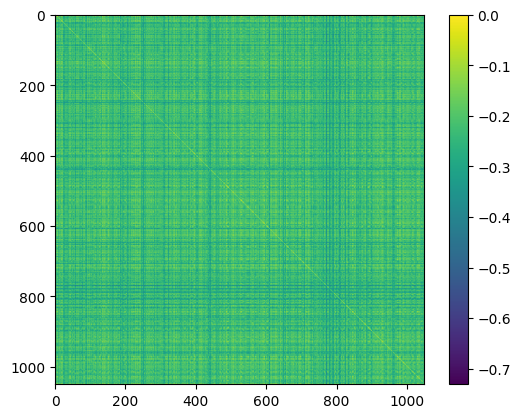

In [90]:
plt.imshow(D)
plt.colorbar()

In [91]:
Y = results['layer1']['activations'][ind_sample].copy()
Y -= np.min(Y, axis=0)
Y /= np.sum(Y, axis=0)
#Y -= np.mean(Y, axis=0)
#Y /= np.std(Y, axis=0)
Y.shape

(1050, 256)

(0.9999999999999999, 0.0)

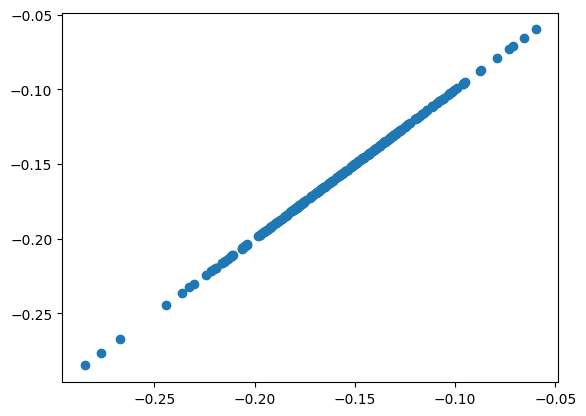

In [92]:
data_train, _ = get_mei_data(Y, X)
scores = -get_monosemanticity(data_train)
plt.scatter(
    -results['layer1']['monosemanticity'],
    scores
)
corr(
    -results['layer1']['monosemanticity'],
    scores
)

In [78]:
for i in range(256):
    ind = np.argsort(Y[:, i])
    Y[ind[:-5], i] *= 0
    Y[ind[-5:], i] = 1

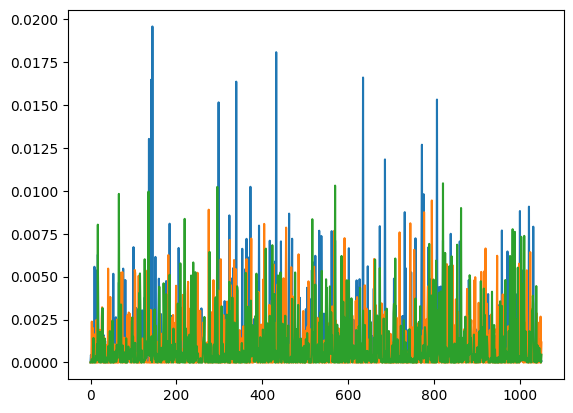

In [93]:
plt.plot(Y[:, :3])
plt.show()

In [94]:
K = Y.T @ D @ Y
K.shape

(256, 256)

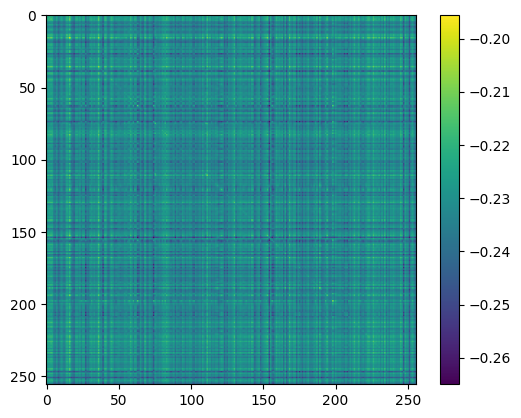

In [95]:
plt.imshow(K)
plt.colorbar()

In [96]:
print(corr(
    -results['layer1']['monosemanticity'],
    np.diag(K)
),

corr(
    scores,
    np.diag(K)
))

(0.36310133709943565, 2.140622274706189e-09) (0.36310133709943565, 2.140622274706189e-09)


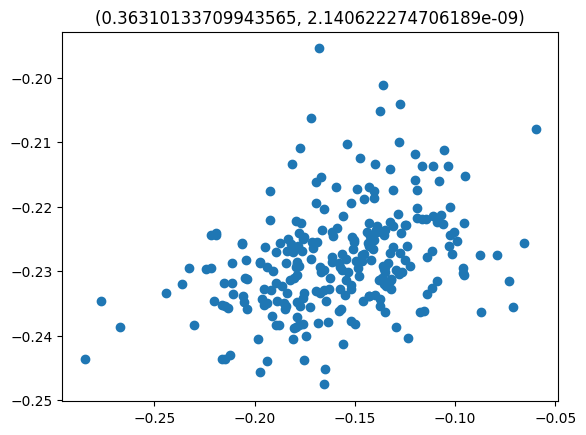

In [97]:
plt.scatter(
    scores,
    np.diag(K)
)
plt.title(corr(
    scores,
    np.diag(K)
))
plt.show()

((256,), (256, 256))

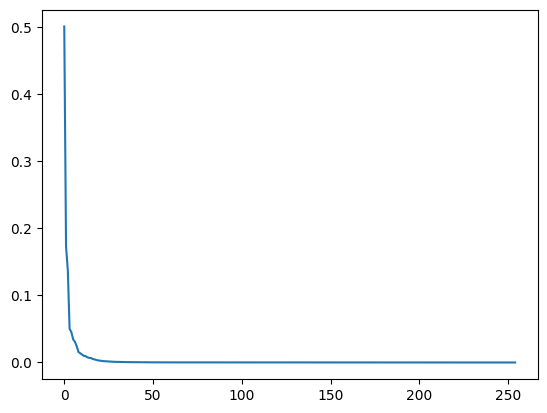

In [99]:
eigenvalues, eigenvectors = np.linalg.eig(K)
plt.plot(eigenvalues[1:])
eigenvalues.shape, eigenvectors.shape, 

In [100]:
Y.shape, X.shape

((1050, 256), (1050, 3, 32, 32))

In [101]:
# check MI of EVs

w = eigenvectors[:, 1].copy()
#y = results['layer1']['activations'] @ w
#x = results['inputs']
y = Y @ w
x = X
y.shape

(1050,)

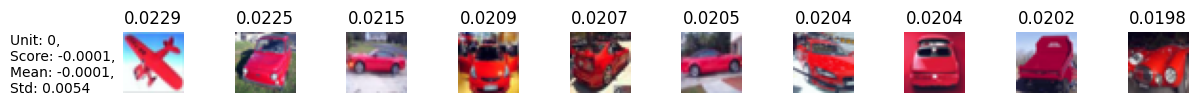

In [102]:
plot_meis(y[:, None], y[:, None].mean(0), x, '',
          num_show=10, show_all=True, plot=True)

In [103]:
data_train, _ = get_mei_data(y[:, None], x)
-get_monosemanticity(data_train)

array([-0.07476194])

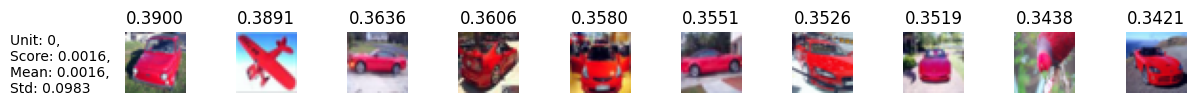

0 [-0.07476194]


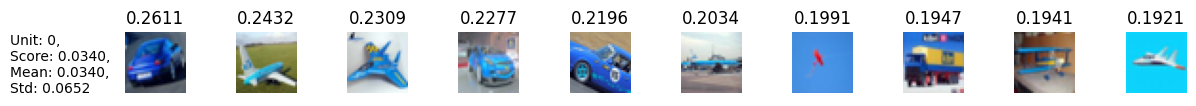

1 [-0.10906294]


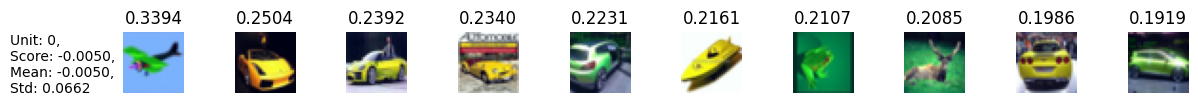

2 [-0.14415488]


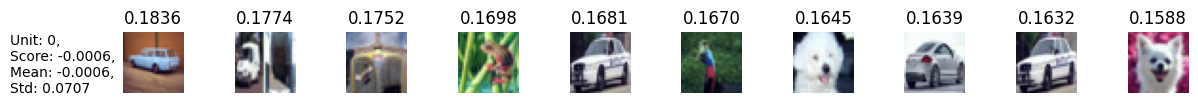

3 [-0.16067591]


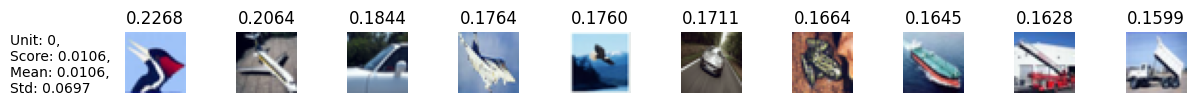

4 [-0.18051773]


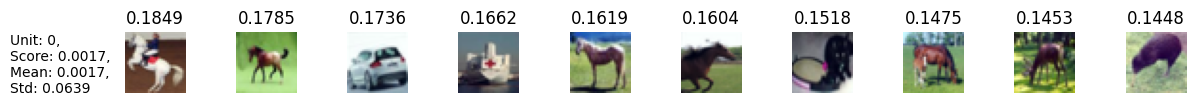

5 [-0.140379]


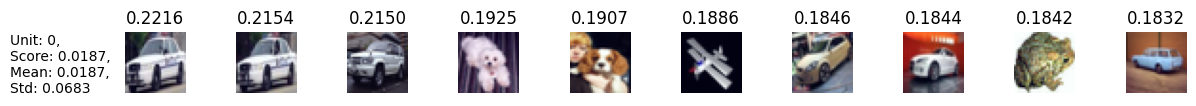

6 [-0.09725735]


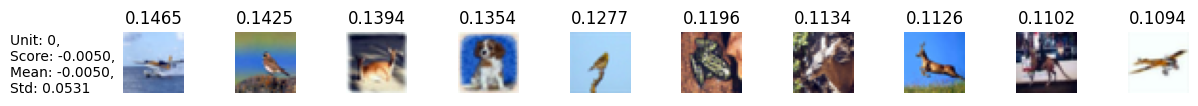

7 [-0.18148704]


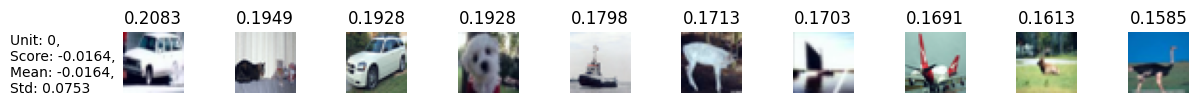

8 [-0.1301873]


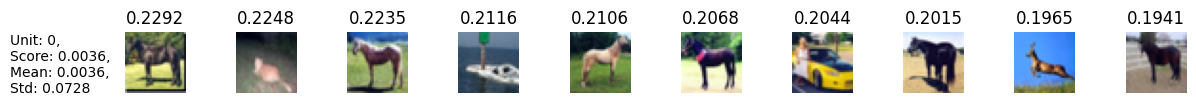

9 [-0.15201877]


In [106]:
for i in range(10):
    w = eigenvectors[:, 1 + i].copy()
    y = results['layer1']['activations'][ind_sample] @ w
    #y = Y @ w
    plot_meis(y[:, None], y[:, None].mean(0), x, '',
          num_show=10, show_all=True, plot=True)
    data_train, _ = get_mei_data(y[:, None], x)
    print(i, -get_monosemanticity(data_train))


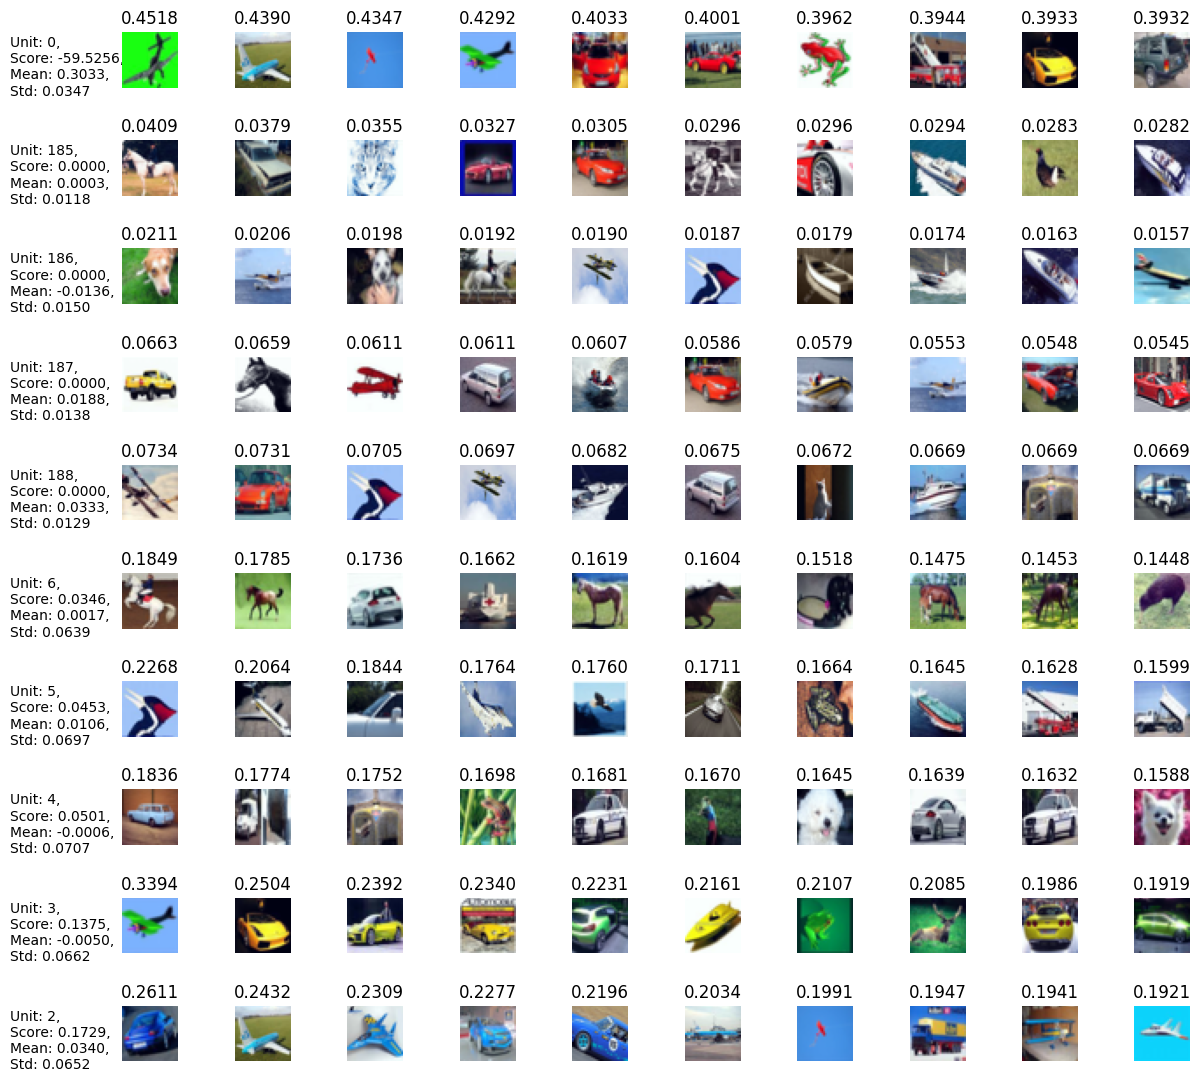

-0.17977037154196296

In [107]:
# all EVs vs scores
Y_ev = results['layer1']['activations'][ind_sample] @ eigenvectors
plot_meis(Y_ev, eigenvalues, x, '', 
      num_show=10, show_all=False, plot=True)
data_train, _ = get_mei_data(Y_ev, x)
scores = -get_monosemanticity(data_train)
np.mean(scores)

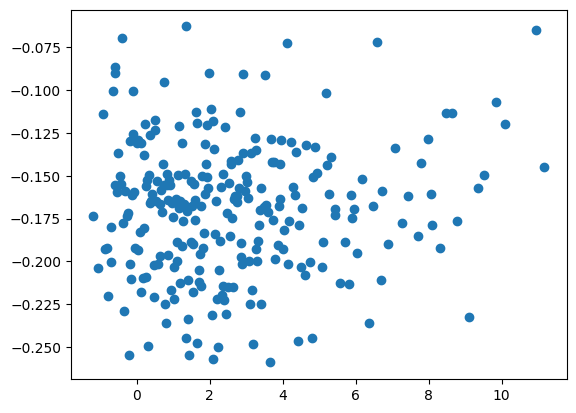

In [75]:
plt.scatter(np.log(abs(eigenvalues[1:])), scores[1:])